# Haplotypes

## Imports

In [1]:
import subprocess
import pandas as pd
from pathlib import Path
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['figure.figsize'] = (11.0, 7.0)

In [2]:
DATA = Path("../data")
RESULTS = Path("../results")

## Read and filter data

In [3]:
gt_filename = str(RESULTS / "glycosyltransferases.txt")
gt = pd.read_table(gt_filename)
variants = pd.read_table(RESULTS / "gt_variants.txt.gz", compression="gzip")

In [4]:
haplotypes = pd.read_table(DATA / "gt_haplotypes.txt")  # .gz", compression="gzip")

In [5]:
haplotype_variants = pd.read_table(DATA / "gt_haplotypes_variants.txt")  # .gz", compression="gzip")

In [6]:
haplotype_prot_variants = pd.read_table(DATA / "gt_protein_haplotypes_variants.txt")  # .gz", compression="gzip")

## Analysis

### Nucleotide haplotypes

In [7]:
haplotypes.head()

haplotypeName      proteinHaplotypeName     transcriptId  \
0  ENST00000236709:139    ENST00000236709:PROT:1  ENST00000236709   
1   ENST00000236709:23    ENST00000236709:PROT:4  ENST00000236709   
2  ENST00000236709:100   ENST00000236709:PROT:10  ENST00000236709   
3   ENST00000236709:54  ENST00000236709:PROT:REF  ENST00000236709   
4  ENST00000236709:237    ENST00000236709:PROT:1  ENST00000236709   

   snvVariantCount  alleleCount  hasDamagingVariant  AFR_allele_count  \
0                6            1               False                 0   
1               12            1               False                 0   
2               13            1                True                 1   
3                5            2               False                 1   
4               14            1               False                 0   

   AFR_freq  AMR_allele_count  AMR_freq  EAS_allele_count  EAS_freq  \
0  0.000000                 0  0.000000                 0  0.000000   
1  0.000000                 0  0.000000                 0  0.000000   
2  0.000756                 0  0.000000                 0  0.000000   
3  0.000756                 1  0.001441                 0  0.000000   
4  0.000000                 0  0.000000                 1  0.000992   

   EUR_allele_count  EUR_freq  SAS_allele_count  SAS_freq  ALL_allele_count  \
0                 0  0.000000                 1  0.001022                 1   
1                 1  0.000994                 0  0.000000                 1   
2                 0  0.000000                 0  0.000000                 1   
3                 0  0.000000                 0  0.000000                 2   
4                 0  0.000000                 0  0.000000                 1   

   ALL_freq  
0  0.000200  
1  0.000200  
2  0.000200  
3  0.000399  
4  0.000200

In [8]:
print(f"There are {len(haplotypes):,} haplotypes.")

There are 540,892 haplotypes.


Distribution of haplotypes per GT.

In [9]:
haplo_counter = Counter(haplotypes["transcriptId"])
haplo_counter = pd.DataFrame.from_dict(haplo_counter, orient="index")
haplo_counter = haplo_counter.reset_index()
haplo_counter.columns = ["transcriptId", "haplotypeCount"]
gt = gt.merge(haplo_counter, on="transcriptId")

Also add protein haplotypes.

In [10]:
prot_haplo_counter = Counter()
for (transcriptId, prot_hap), group in haplotypes.groupby(["transcriptId", "proteinHaplotypeName"]):
    prot_haplo_counter[transcriptId] += 1
prot_haplo_counter = pd.DataFrame.from_dict(prot_haplo_counter, orient="index")
prot_haplo_counter = prot_haplo_counter.reset_index()
prot_haplo_counter.columns = ["transcriptId", "proteinHaplotypeCount"]
gt = gt.merge(prot_haplo_counter, on="transcriptId")

In [11]:
print("There are", gt["proteinHaplotypeCount"].sum(), "protein haplotypes")

There are 8289 protein haplotypes


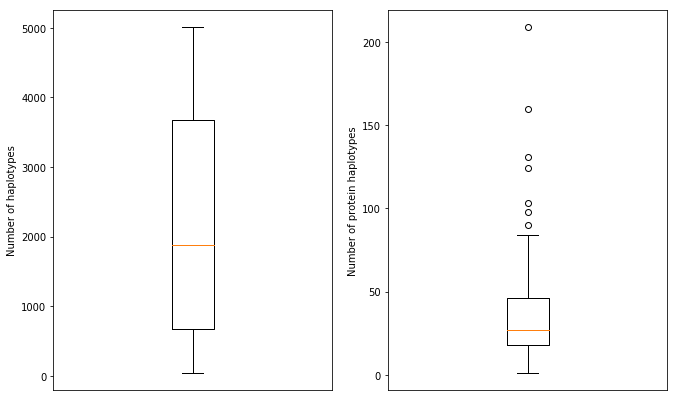

In [12]:
fig, axes = plt.subplots(1, 2)
axes[0].boxplot(gt["haplotypeCount"])
axes[0].set(ylabel="Number of haplotypes")
axes[0].get_xaxis().set_visible(False)

axes[1].boxplot(gt["proteinHaplotypeCount"])
axes[1].set(ylabel="Number of protein haplotypes")
axes[1].get_xaxis().set_visible(False)

In [13]:
gt[["haplotypeCount", "proteinHaplotypeCount"]].describe()

haplotypeCount  proteinHaplotypeCount
count      244.000000             244.000000
mean      2216.770492              33.971311
std       1663.650210              25.169941
min         40.000000               1.000000
25%        676.000000              18.000000
50%       1880.500000              27.000000
75%       3674.750000              46.000000
max       5008.000000             209.000000

GTs with the most and least number of haplotypes.

In [14]:
cols = ["geneSymbol", "transcriptId", "geneLength", "transcriptLength", "proteinLength", "haplotypeCount",
        "proteinHaplotypeCount", "orphanet"]
gt.nlargest(5, "haplotypeCount")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
116     GALNTL6  ENST00000506823     1229306              3922            601   
158      LARGE1  ENST00000354992      760616              4409            756   
37     B4GALNT3  ENST00000266383      103146              5068            998   
132  ST6GALNAC3  ENST00000328299      559883              6861            305   
166       MGAT5  ENST00000409645      334639              8252            741   

     haplotypeCount  proteinHaplotypeCount        orphanet  
116            5008                     21             NaN  
158            5008                     28  370968,588,899  
37             5007                    160             NaN  
132            5006                     26             NaN  
166            5005                     26             NaN

In [15]:
gt.nsmallest(5, "haplotypeCount")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
26    B3GALNT2  ENST00000366600       54559              2015            500   
52   C1GALT1C1  ENST00000304661        4358              1613            318   
25      B4GAT1  ENST00000311181        2321              2072            415   
23      B3GNT9  ENST00000449549        3110              2917            402   
168      MGAT2  ENST00000305386        2687              2687            447   

     haplotypeCount  proteinHaplotypeCount orphanet  
26               40                      3  588,899  
52               43                      7      NaN  
25               45                     13      899  
23               82                     18      NaN  
168              85                     23    79329

Protein haplotypes.

In [16]:
gt.nlargest(5, "proteinHaplotypeCount")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
191      PARP4  ENST00000381989       91885              5474           1724   
37    B4GALNT3  ENST00000266383      103146              5068            998   
182     PARP15  ENST00000464300       61446              2156            678   
238      UGGT2  ENST00000376747      251903              4832           1516   
241      XYLT1  ENST00000261381      369113              9891            959   

     haplotypeCount  proteinHaplotypeCount     orphanet  
191            4553                    209          NaN  
37             5007                    160          NaN  
182            3413                    131          NaN  
238            4640                    124          NaN  
241            5000                    103  1425,370930

In [17]:
gt.nsmallest(5, "proteinHaplotypeCount")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
148    ST6GAL1  ENST00000169298      148069              4645            406   
155      HPRT1  ENST00000298556       60361              1407            218   
163     MGAT4C  ENST00000611864      883239             25116            478   
176        OGT  ENST00000373719       42815              5461           1046   
96      GALNT2  ENST00000366672      224135              4454            571   

     haplotypeCount  proteinHaplotypeCount   orphanet  
148             736                      1        NaN  
155             932                      1  79233,510  
163             632                      1        NaN  
176             435                      1        NaN  
96             4673                      2        NaN

Four GTs have only a single protein haplotype count.

In [18]:
variants[variants["transcriptId"] == "ENST00000298556"]["consequenceTerms"].value_counts()

intron_variant             340
downstream_gene_variant    176
3_prime_UTR_variant          4
synonymous_variant           1
5_prime_UTR_variant          1
Name: consequenceTerms, dtype: int64

_HPRT1_ does not have a single amino acid-altering variant, hence the single protein haplotype.

_B4GALNT3_ has a very large number of haplotypes despite being of moderate length.

In [19]:
variants[variants["transcriptId"] == "ENST00000266383"]["consequenceTerms"].value_counts()

intron_variant                              3522
3_prime_UTR_variant                           92
missense_variant                              85
synonymous_variant                            39
splice_region_variant,intron_variant           5
missense_variant,splice_region_variant         5
stop_gained                                    3
inframe_deletion                               1
splice_acceptor_variant                        1
splice_region_variant,synonymous_variant       1
Name: consequenceTerms, dtype: int64

In [20]:
variants[variants["transcriptId"] == "ENST00000266383"]["impact"].value_counts()

MODIFIER    3614
MODERATE      91
LOW           45
HIGH           4
Name: impact, dtype: int64

There are several moderate-high impact variants in _B3GALNT4_.

## Moderate-high impact variants in haplotypes

In [21]:
def impact_in_haplotypes(hap_df, hap_variant_df, variant_df, level="HIGH"):
    
    damaging_variants = variant_df[variant_df["impact"] == level]
    damaging_variants_ids = set(damaging_variants["id"])
    
    damaged_haplotypes = hap_variant_df[hap_variant_df["variantId"].isin(damaging_variants_ids)]
    damaged_haplotypes_ids = set(damaged_haplotypes["haplotypeName"])
    
    return hap_df["haplotypeName"].isin(damaged_haplotypes_ids)

In [22]:
haplotypes["highImpactVariant"] = impact_in_haplotypes(haplotypes, haplotype_variants, variants, "HIGH")

In [23]:
haplotypes["moderateImpactVariant"] = impact_in_haplotypes(haplotypes, haplotype_variants, variants, "MODERATE")

Calculate the proportion of haplotypes with high impact variants per glycosyltransferase.

In [24]:
def high_impact_freq(df):
    transcript_ids = []
    freqs = []
    for transcriptId, group in haplotypes.groupby("transcriptId"):
        freq = group[group["highImpactVariant"]]["ALL_freq"].sum()
        
        transcript_ids.append(transcriptId)
        freqs.append(freq)
        
    return pd.DataFrame({"transcriptId": transcript_ids, "highImpactVariantFreq": freqs})

In [25]:
gt = gt.merge(high_impact_freq(haplotypes), on="transcriptId")

# remove some dummy column
if "Unnamed: 0" in gt.columns:
    del gt["Unnamed: 0"]
# gt.merge(high_impact_freq(haplotypes), on="transcriptId").drop("Unnamed: 0", axis=1)

In [26]:
cols = ["geneSymbol", "orphanet", "variantCount", "aaAlteringVariantCount", "haplotypeCount",
        "proteinHaplotypeCount", "highImpactVariantFreq"] 

gt[cols].sort_values("highImpactVariantFreq")

geneSymbol                                           orphanet  \
243      XXYLT1                                                NaN   
76         FUT7                                                NaN   
75         FUT4                                                NaN   
155       HPRT1                                          79233,510   
156        HAS2                                                NaN   
157      KDELC1                                                NaN   
158      LARGE1                                     370968,588,899   
160       MGAT1                                                NaN   
69         EXT1                                      55880,502,321   
161       MGAT3                                                NaN   
163      MGAT4C                                                NaN   
77         EXT2                                          321,52022   
165      MGAT4A                                                NaN   
63      DPY19L3                                                NaN   
169        MTAP                                              85182   
61        CHSY3                                                NaN   
170       NAMPT                                                NaN   
118      GXYLT1                                                NaN   
57         UGCG                                                NaN   
56   CSGALNACT2                                                NaN   
174        QPRT                                                NaN   
54         UGT8                                                NaN   
53      C1GALT1                                                NaN   
166       MGAT5                                                NaN   
52    C1GALT1C1                                                NaN   
154        HAS3                                                NaN   
151        TNKS                                                NaN   
114     GALNT13                                                NaN   
112     GALNT16                                                NaN   
242       XYLT2                                                NaN   
..          ...                                                ...   
66      DPY19L2                                             171709   
212       STT3B                                             370924   
70         EOGT                                                974   
225      UGT1A4                                                NaN   
67        EXTL2                                                NaN   
228      UGT1A5                                                NaN   
222      UGT1A6                                                NaN   
220      UGT1A7                                                NaN   
231      UGT1A9                                                NaN   
227     UGT1A10                                                NaN   
223      UGT1A8                                                NaN   
240      UGT2A1                                                NaN   
1       A3GALT2                                                NaN   
41      B3GALT1                                                NaN   
80         FUT6                                                NaN   
128       POMT1                 86812,370959,370968,370980,588,899   
233     UGT2B11                                                NaN   
217      UGT2B4                                                NaN   
215        UPP2                                                NaN   
224      UGT2B7                                                NaN   
102      GLT6D1                                                NaN   
101        GBE1  206583,308712,308684,308698,308670,308655,3086...   
74         FUT2                                                NaN   
167      MGAT5B                                                NaN   
31          ABO                                                NaN   
5        ALG1L2

Do GTs with Orphanet entries have a higher frequency of high impact variant-containing haplotypes?

In [27]:
def test_orpha_high_impact(df):
    with_orpha = gt[gt["orphanet"].notnull()]["highImpactVariantFreq"]
    without_orpha = gt[gt["orphanet"].isnull()]["highImpactVariantFreq"]
    return stats.mannwhitneyu(with_orpha, without_orpha)

def plot_orpha_high_impact(df):
    with_orpha = gt[gt["orphanet"].notnull()]["highImpactVariantFreq"]
    without_orpha = gt[gt["orphanet"].isnull()]["highImpactVariantFreq"]
    fig, ax = plt.subplots()
    
    ax.hist(with_orpha, label="With Orphanet entry", alpha=0.5)
    ax.hist(without_orpha, label="Without Orphanet entry", alpha=0.5)
    ax.legend()
    return fig

In [28]:
test_orpha_high_impact(gt)

MannwhitneyuResult(statistic=5422.0, pvalue=0.46942050975007921)

No significant differences.

## Haplotypes in populations

Find haplotypes that are present in a single superpopulation only.

In [29]:
def pop_haplotypes(df):
    
    def get_col(pop):
        return f"{pop}_freq"

    pops = ["AFR", "AMR", "EAS", "EUR", "SAS"]
    cols = [get_col(p) for p in pops]
    
    queries = {}

    # build a DataFrame.query string for every column in cols, other columns should be 0.0
    for pop, col in zip(pops, cols):
        query = f"{col} > 0.0"
        for other_col in cols:
            if other_col == col:
                continue
            query += f" and {other_col} == 0.0"
            
        queries[pop] = query
    
    data = []
    
    for transcriptId, group in df.groupby("transcriptId"):
        
        private_data = {"transcriptId": transcriptId}
        all_private = 0
                
        for pop, query in queries.items():
 
            # private to one population
            private = group.query(query)
            
            # per transcript and population, save id, number of private and the sum of
            # their frequencies
            private_data[pop + "_private_count"] = len(private)
            private_data[pop + "_private_freq"] = private[get_col(pop)].sum()
            
            all_private += len(private)
            
        private_data["ALL_private_count"] = all_private
        private_data["ALL_private_freq"] = all_private / group["ALL_allele_count"].sum()
        data.append(private_data)
    
    return pd.DataFrame.from_records(data)

In [30]:
private_haplotypes = pop_haplotypes(haplotypes)
# add gene symbol
private_haplotypes = private_haplotypes.merge(gt[["transcriptId", "geneSymbol"]], on="transcriptId")

The GTs with the lowest number of private haplotypes (across all populations).

In [31]:
private_haplotypes.nsmallest(10, "ALL_private_freq")

AFR_private_count  AFR_private_freq  ALL_private_count  ALL_private_freq  \
134                 12          0.043873                 26          0.005192   
70                   7          0.057827                 22          0.005828   
87                  17          0.035552                 35          0.006989   
209                 20          0.052194                 65          0.012979   
76                  20          0.019667                 71          0.014177   
169                 36          0.097579                 90          0.017971   
139                 37          0.061271                 94          0.018770   
88                  26          0.083207                102          0.020367   
93                  45          0.148260                119          0.023762   
216                 43          0.126324                120          0.023962   

     AMR_private_count  AMR_private_freq  EAS_private_count  EAS_private_freq  \
134                  2          0.002882                  3          0.002976   
70                   2          0.005725                  5          0.020942   
87                   3          0.004323                  7          0.025794   
209                  5          0.023055                 16          0.020833   
76                  11          0.020173                 13          0.061508   
169                  9          0.015850                 16          0.056548   
139                  8          0.024496                 18          0.031746   
88                  17          0.034582                 21          0.040675   
93                   9          0.012968                 28          0.076389   
216                 17          0.028818                 12          0.016865   

     EUR_private_count  EUR_private_freq  SAS_private_count  SAS_private_freq  \
134                  4          0.003976                  5          0.012270   
70                   7          0.015666                  1          0.001393   
87                   1          0.000994                  7          0.016360   
209                 13          0.015905                 11          0.014315   
76                  13          0.012922                 14          0.048057   
169                 12          0.012922                 17          0.028630   
139                 14          0.019881                 17          0.036810   
88                  15          0.015905                 23          0.038855   
93                   8          0.008946                 29          0.042945   
216                 20          0.031809                 28          0.071575   

        transcriptId geneSymbol  
134  ENST00000366600   B3GALNT2  
70   ENST00000304661  C1GALT1C1  
87   ENST00000311181     B4GAT1  
209  ENST00000449549     B3GNT9  
76   ENST00000305386      MGAT2  
169  ENST00000379198    B3GALT6  
139  ENST00000368090       PIGM  
88   ENST00000314412       FUT7  
93   ENST00000321702     B3GNT8  
216  ENST00000476832       ALG2

The GTs with the highest number of private haplotypes across all populations.

In [32]:
private_haplotypes.nlargest(10, "ALL_private_freq")

AFR_private_count  AFR_private_freq  ALL_private_count  ALL_private_freq  \
125               1322          1.000000               5008          1.000000   
220               1322          1.000000               5008          1.000000   
50                1322          1.000000               5007          0.999800   
102               1321          1.000000               5005          0.999401   
197               1321          1.000000               5005          0.999401   
18                1321          1.000000               5000          0.998403   
38                1321          1.000000               5000          0.998403   
195               1321          1.000000               5000          0.998403   
187               1314          1.000000               4993          0.997005   
233               1315          0.999244               4990          0.996406   

     AMR_private_count  AMR_private_freq  EAS_private_count  EAS_private_freq  \
125                694          1.000000               1008          1.000000   
220                694          1.000000               1008          1.000000   
50                 694          1.000000               1008          1.000000   
102                693          0.998559               1008          1.000000   
197                694          1.000000               1008          1.000000   
18                 691          1.000000               1007          1.000000   
38                 692          1.000000               1005          1.000000   
195                691          1.000000               1007          1.000000   
187                694          1.000000               1005          1.000000   
233                691          1.000000               1007          0.999008   

     EUR_private_count  EUR_private_freq  SAS_private_count  SAS_private_freq  \
125               1006          1.000000                978          1.000000   
220               1006          1.000000                978          1.000000   
50                1006          1.000000                977          1.000000   
102               1005          0.999006                978          1.000000   
197               1004          1.000000                978          1.000000   
18                1006          1.000000                975          1.000000   
38                1005          1.000000                977          1.000000   
195               1003          1.000000                978          1.000000   
187               1002          1.000000                978          1.000000   
233               1002          0.999006                975          0.998978   

        transcriptId  geneSymbol  
125  ENST00000354992      LARGE1  
220  ENST00000506823     GALNTL6  
50   ENST00000266383    B4GALNT3  
102  ENST00000328299  ST6GALNAC3  
197  ENST00000409645       MGAT5  
18   ENST00000227756     GALNT18  
38   ENST00000261381       XYLT1  
195  ENST00000409237     GALNT13  
187  ENST00000396037     ST8SIA1  
233  ENST00000605860        UPP2

In [33]:
print("Out of all {:,} haplotypes, {:,.0f} ({:.2%}) are unique to one superpopulation.".format(
    len(haplotypes),
    private_haplotypes["ALL_private_count"].sum(),
    private_haplotypes["ALL_private_count"].sum() / len(haplotypes)))  

Out of all 540,892 haplotypes, 511,844 (94.63%) are unique to one superpopulation.


#### Private protein haplotypes 

In [34]:
def pop_protein_haplotypes(df):
    
    def get_col(pop):
        return f"{pop}_freq"

    pops = ["AFR", "AMR", "EAS", "EUR", "SAS"]
    cols = [get_col(p) for p in pops]
    
    queries = {}
    for pop, col in zip(pops, cols):
        new_cols = [new_col for new_col in cols if not new_col == col]
        queries[(pop, col)] = new_cols
     
    # for indexing, queries:
    # {
    #     ("AFR", "AFR_freq"): ["EUR_freq", "AMR_freq", "EAS_freq", "SAS_freq"],
    #     ...
    # }

    data = []
    
    for transcriptId, transcript_group in df.groupby("transcriptId"):
    
        private_data = {"transcriptId": transcriptId}

        prot_hap_count = {pop + "_private_count": 0 for pop in pops}
        prot_hap_freq = {pop + "_private_freq": 0.0 for pop in pops}
        prot_hap_freq["ALL_private_freq"] = 0.0
                
        for proteinHaplotypeName, group in transcript_group.groupby("proteinHaplotypeName"):
            
            # sums of each column
            sums = group.sum()
            
            for key, index_cols in queries.items():
                pop, freq_col = key

                if sums[freq_col] > 0.0 and sums[index_cols].sum() == 0.0:
                    prot_hap_count[pop + "_private_count"] += 1
                    prot_hap_freq[pop + "_private_freq"] += sums[freq_col]
                    prot_hap_freq["ALL_private_freq"] += sums["ALL_freq"]
                            
        for pop, value in prot_hap_count.items():
            private_data[pop] = value
            
        for pop, value in prot_hap_freq.items():
            private_data[pop] = value
        
        private_data["ALL_private_count"] = sum(prot_hap_count.values())
        data.append(private_data)
    
    return pd.DataFrame.from_records(data)

In [35]:
private_prot_haplotypes = pop_protein_haplotypes(haplotypes)
private_prot_haplotypes = private_prot_haplotypes.merge(gt[["transcriptId", "geneSymbol"]], on="transcriptId")

The GTs with the highest number of private protein haplotypes (across all populations).

In [36]:
private_prot_haplotypes.nlargest(10, "ALL_private_freq")

AFR_private_count  AFR_private_freq  ALL_private_count  ALL_private_freq  \
174                 97          0.194402                168          0.072085   
165                 22          0.070348                106          0.049521   
214                 75          0.144478                105          0.048722   
50                  46          0.076399                127          0.044728   
218                 12          0.026475                 52          0.037141   
31                  20          0.075643                 50          0.034744   
59                  29          0.062784                 81          0.033946   
115                 18          0.068835                 53          0.030950   
3                   19          0.059758                 61          0.029553   
201                 16          0.050681                 48          0.028954   

     AMR_private_count  AMR_private_freq  EAS_private_count  EAS_private_freq  \
174                  8          0.014409                 28          0.047619   
165                 14          0.027378                 24          0.030754   
214                  4          0.005764                 19          0.037698   
50                  15          0.027378                 32          0.057540   
218                  5          0.010086                 15          0.080357   
31                   6          0.011527                 10          0.012897   
59                   7          0.011527                 19          0.032738   
115                  8          0.012968                  6          0.007937   
3                    6          0.011527                 10          0.021825   
201                  6          0.027378                  7          0.026786   

     EUR_private_count  EUR_private_freq  SAS_private_count  SAS_private_freq  \
174                 18          0.023857                 17          0.022495   
165                 18          0.023857                 28          0.082822   
214                  4          0.004970                  3          0.006135   
50                  17          0.022863                 17          0.023517   
218                  5          0.005964                 15          0.058282   
31                   6          0.006958                  8          0.047035   
59                  10          0.011928                 16          0.034765   
115                  8          0.007952                 13          0.039877   
3                   12          0.014911                 14          0.024540   
201                  7          0.007952                 12          0.024540   

        transcriptId geneSymbol  
174  ENST00000381989      PARP4  
165  ENST00000376747      UGGT2  
214  ENST00000464300     PARP15  
50   ENST00000266383   B4GALNT3  
218  ENST00000482026     UGT1A3  
31   ENST00000252318     GALNT8  
59   ENST00000294724        AGL  
115  ENST00000339732    GALNT15  
3    ENST00000035307      CHPF2  
201  ENST00000425340       FUT2

The GTs with the lowest number of private haplotypes (across all populations).

In [37]:
private_prot_haplotypes.nsmallest(10, "ALL_private_freq")

AFR_private_count  AFR_private_freq  ALL_private_count  ALL_private_freq  \
7                    0          0.000000                  0          0.000000   
63                   0          0.000000                  0          0.000000   
157                  0          0.000000                  0          0.000000   
236                  0          0.000000                  0          0.000000   
135                  0          0.000000                  1          0.000200   
134                  0          0.000000                  2          0.000399   
70                   0          0.000000                  2          0.000530   
159                  1          0.000756                  5          0.000998   
10                   1          0.000756                  5          0.001198   
42                   0          0.000000                  2          0.001198   

     AMR_private_count  AMR_private_freq  EAS_private_count  EAS_private_freq  \
7                    0               0.0                  0          0.000000   
63                   0               0.0                  0          0.000000   
157                  0               0.0                  0          0.000000   
236                  0               0.0                  0          0.000000   
135                  0               0.0                  1          0.000992   
134                  0               0.0                  1          0.000992   
70                   0               0.0                  0          0.000000   
159                  0               0.0                  1          0.000992   
10                   0               0.0                  1          0.001984   
42                   0               0.0                  0          0.000000   

     EUR_private_count  EUR_private_freq  SAS_private_count  SAS_private_freq  \
7                    0          0.000000                  0          0.000000   
63                   0          0.000000                  0          0.000000   
157                  0          0.000000                  0          0.000000   
236                  0          0.000000                  0          0.000000   
135                  0          0.000000                  0          0.000000   
134                  1          0.000994                  0          0.000000   
70                   1          0.001305                  1          0.001393   
159                  2          0.001988                  1          0.001022   
10                   3          0.002982                  0          0.000000   
42                   1          0.000994                  1          0.005112   

        transcriptId geneSymbol  
7    ENST00000169298    ST6GAL1  
63   ENST00000298556      HPRT1  
157  ENST00000373719        OGT  
236  ENST00000611864     MGAT4C  
135  ENST00000366672     GALNT2  
134  ENST00000366600   B3GALNT2  
70   ENST00000304661  C1GALT1C1  
159  ENST00000374279       UGCG  
10   ENST00000216452       PIGH  
42   ENST00000262915    ST3GAL3

In [38]:
prot_haplo_count = haplotypes["proteinHaplotypeName"].nunique()
print("Out of all {:,} protein haplotypes, {:,.0f} ({:.2%}) are unique to one superpopulation.".format(
    prot_haplo_count,
    private_prot_haplotypes["ALL_private_count"].sum(),
    private_prot_haplotypes["ALL_private_count"].sum() / prot_haplo_count)
)

Out of all 8,289 protein haplotypes, 6,589 (79.49%) are unique to one superpopulation.


## Write data to file

Write the changes we have made to file.

In [39]:
gt.to_csv(gt_filename, sep="\t", index=False)

name = str(RESULTS / "gt_haplotypes.txt")
haplotypes.to_csv(name, sep="\t", index=False)
subprocess.run(["pigz", "-f", name])

name = str(RESULTS / "gt_haplotypes_variants.txt")
haplotype_variants.to_csv(name, sep="\t", index=False)
subprocess.run(["pigz", "-f", name])

name = str(RESULTS / "gt_protein_haplotypes_variants.txt")
haplotype_prot_variants.to_csv(name, sep="\t", index=False)
subprocess.run(["pigz", "-f", name])

CompletedProcess(args=['pigz', '-f', '../results/gt_protein_haplotypes_variants.txt'], returncode=0)